In [1]:
import sys
import os
sys.path.insert(0, os.path.abspath(os.path.join('..')))
sys.path.insert(0, os.path.abspath(os.path.join('../core')))
import numpy as np
import pickle
import numpy as np
from functools import partial
import tensorflow as tf

from keras import backend as K
from keras.models import Sequential, Model, load_model
from keras.layers import Input, Lambda, Subtract, Dense
from keras.layers.merge import _Merge
from keras.activations import relu
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import RMSprop
from keras.callbacks import EarlyStopping
from keras.datasets import mnist
from keras.losses import mse

import train
import costs
from data import predict_with_K_fn
from layer import stack_layers
from util import LearningHandler, make_layer_list, train_gen, get_scale

from sklearn.manifold import TSNE

%matplotlib inline

os.environ['CUDA_VISIBLE_DEVICES'] = '0'

Using TensorFlow backend.


# DATASET AND USEFUL FUNCTION DEFINITIONS

In [2]:
def predict_with_K_fn(K_fn, x, bs=1000):
    '''
    Convenience function: evaluates x by K_fn(x), where K_fn is
    a Keras function, by batches of size 1000.
    '''
    if not isinstance(x, list):
        x = [x]
    num_outs = len(K_fn.outputs)
    shapes = [list(output_.get_shape()) for output_ in K_fn.outputs]
    shapes = [[len(x[0])] + s[1:] for s in shapes]
    y = [np.empty(s) for s in shapes]
    recon_means = []
    for i in range(int((x[0].shape[0]-1)/bs + 1)):
        x_batch = []
        for x_ in x:
            x_batch.append(x_[i*bs:(i+1)*bs])
        temp = K_fn(x_batch)
        for j in range(num_outs):
            y[j][i*bs:(i+1)*bs] = temp[j]

    return y

In [3]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
sns.set_context('paper')
from matplotlib.colors import ListedColormap
# cmap1 = ListedColormap(sns.color_palette().as_hex())
# cmap2 = ListedColormap(sns.color_palette('bright').as_hex())
def plot(x, y=None, x2=None, y2=None, s=10, s2=None, alpha=0.5, label1=None, label2=None, cmap1=None, cmap2=None):
    s2 = s if s2 is None else s2
    n = x.shape[1]
    if n == 1:
        g = plt.figure()
        plt.scatter(np.zeros((n,)), x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(np.zeros((n,)), x2[:,1], c=y2, s=s2, alpha=alpha, label=label2, cmap=cmap2)
    if n == 3:
        %matplotlib notebook
        g = plt.figure()
        ax = g.add_subplot(111, projection='3d')
        ax.scatter(x[:,0], x[:,1], x[:,2], c=y, s=s, alpha=alpha, label=label1)
        if x2 is not None:
            ax.scatter(x2[:,0], x2[:,1], x2[:,2], c=y2, s=s2, alpha=alpha, label=label2)
    elif n == 784:
        %matplotlib inline
        n_imgs = 10
        # num = 7
        # sub = y == num
        sub = y == y
        for i in range(n_imgs):
            idx = np.random.randint(len(x[sub]))
            if x2 is not None:
                plt.subplot(1,2,1)
                plt.imshow(x2[sub][idx].reshape(28, 28))
            plt.subplot(1,2,2)
            plt.imshow(x[sub][idx].reshape(28, 28))
            g = plt.figure()
    else:
        g = plt.figure()
        plt.scatter(x[:,0], x[:,1], c=y, s=s, alpha=alpha, label=label1, cmap=cmap1)
        if x2 is not None:
            plt.scatter(x2[:,0], x2[:,1], c=y2, s=s2, alpha=alpha, label=label2, cmap=cmap2)
            
    if label1 is not None or label2 is not None:
        plt.legend()
        
    return g

In [4]:
def generate_loop(n=1200, train_set_fraction=.8):
    t = np.linspace(0, 2*np.pi, num=n)
    
    # generate all three coordinates
    x = np.empty((n, 3))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(2*t)
    x[:,2] = np.sin(3*t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_circle(n=1000, train_set_fraction=.8, alpha=4):
    t = np.linspace(0, 2*np.pi, num=n)
#     t = np.log(np.linspace(1, alpha, num=n))
    t = t / np.max(t) * 2 * np.pi
    
    # generate all three coordinates
    x = np.empty((n, 2))
    x[:,0] = np.cos(t)
    x[:,1] = np.sin(t)
    
    # y is just t
    y = t
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_line(n=1200, train_set_fraction=.8):
    pts_per_cluster = int(n / 2)
    x1 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x2 = np.linspace(0, 1, num=n).reshape((-1, 1))
    x = np.concatenate([x1, x2], axis=1)
    
    # generate labels
#     y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)
    y = x1
    
    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_gaussians(n=1200, n_clusters=2, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / n_clusters)
    r = 1
    
    clusters = []
    
    for x in np.linspace(0, 1, num=n_clusters):
        clusters.append(np.random.normal(x, noise_sigma, size=(pts_per_cluster, 2)))

    # combine clusters
    x = np.concatenate(clusters, axis=0)
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

def generate_cc(n=1200, noise_sigma=0.1, train_set_fraction=1.):
    '''
    Generates and returns the nested 'C' example dataset (as seen in the leftmost
    graph in Fig. 1)
    '''
    pts_per_cluster = int(n / 2)
    r = 1

    # generate clusters
    theta1 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)
    theta2 = (np.random.uniform(0, 1, pts_per_cluster) * r * np.pi - np.pi / 2).reshape(pts_per_cluster, 1)

    cluster1 = np.concatenate((np.cos(theta1) * r, np.sin(theta1) * r), axis=1)
    cluster2 = np.concatenate((np.cos(theta2) * r, np.sin(theta2) * r), axis=1)

    # shift and reverse cluster 2
    cluster2[:, 0] = -cluster2[:, 0] + 0.5
    cluster2[:, 1] = -cluster2[:, 1] - 1

    # combine clusters
    x = np.concatenate((cluster1, cluster2), axis=0)

    # add noise to x
    x = x + np.random.randn(x.shape[0], 2) * noise_sigma
    print(np.max(x), np.min(x))
    x /= (np.max(x) - np.min(x))
    print(np.max(x), np.min(x))
    x -= np.min(x)
    print(np.max(x), np.min(x))

    # generate labels
    y = np.concatenate((np.zeros(shape=(pts_per_cluster, 1)), np.ones(shape=(pts_per_cluster, 1))), axis=0)

    # shuffle
    p = np.random.permutation(n)
    y = y[p]
    x = x[p]

    # make train and test splits
    n_train = int(n * train_set_fraction)
    x_train, x_test = x[:n_train], x[n_train:]
    y_train, y_test = y[:n_train].flatten(), y[n_train:].flatten()

    return (x_train, y_train), (x_test, y_test)

In [5]:
dataset = 'loop'

if dataset == 'mnist':
#     (x_train, y_train), (x_test, y_test) = mnist.load_data()
#     x_train, x_test = x_train.reshape((-1, 784)), x_test.reshape((-1, 784))
    (x_train, y_train), (x_test, y_test) = mnist.load_data()
    # reshape and standardize x arrays
    x_train = x_train.reshape(len(x_train), -1) / 255
    x_test = x_test.reshape(len(x_test), -1) / 255
    latent_dim = 9
elif dataset == 'gaussians':
    (x_train, y_train), (x_test, y_test) = generate_gaussians(n=2000, n_clusters=1, train_set_fraction=0.85)
    latent_dim = 6
elif dataset == 'line':
    (x_train, y_train), (x_test, y_test) = generate_line(n=2000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'loop':
    (x_train, y_train), (x_test, y_test) = generate_loop(n=10000, train_set_fraction=0.85)
    latent_dim = 2
elif dataset == 'cc':
    (x_train, y_train), (x_test, y_test) = generate_cc(n=2000, noise_sigma=0.1, train_set_fraction=0.85)
    latent_dim = 3
elif dataset == 'circle':
    (x_train, y_train), (x_test, y_test) = generate_circle(n=1024, train_set_fraction=0.85, alpha=30)
    latent_dim = 2

x_all = np.concatenate([x_train, x_test], axis=0)
    
# normalize to between -1 and 1
if dataset != 'mnist':
    m, M = np.min(x_train), np.max(x_train)
    a = (M + m) / 2
    b = (M - m) / 2
    x_train, x_test = (x_train - a) / b, (x_test - a) / b
print('IMPORTANT: max {}, min {}'.format(np.max(x_train), np.min(x_train)))

arch = [
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 128},
    {'type': 'relu', 'size': 512},
    {'type': 'linear', 'size': 16},
    ]

IMPORTANT: max 1.0, min -1.0


# MODEL DEFINITIONS

In [6]:
class SpectralNet:
    def __init__(self, inputs, arch, spec_reg, y_true, y_train_labeled_onehot,
            n_clusters, affinity, scale_nbr, n_nbrs, batch_sizes, normalized=False,
            siamese_net=None, x_train=None, have_labeled=False):
        self.y_true = y_true
        self.y_train_labeled_onehot = y_train_labeled_onehot
        self.inputs = inputs
        self.batch_sizes = batch_sizes
        self.normalized = normalized
        # generate layers
        self.layers = make_layer_list(arch[:-1], 'spectral', spec_reg)
        self.layers += [
                  {'type': 'tanh',
                   'size': n_clusters,
                   'l2_reg': spec_reg,
                   'name': 'spectral_{}'.format(len(arch)-1)},
                  {'type': 'Orthonorm', 'name':'orthonorm'}
                  ]

        # create spectralnet
        self.outputs = stack_layers(self.inputs, self.layers)
        self.net = Model(inputs=self.inputs['Unlabeled'], outputs=self.outputs['Unlabeled'])

        # DEFINE LOSS

        # generate affinity matrix W according to params
        if affinity == 'siamese':
            input_affinity = tf.concat([siamese_net.outputs['A'], siamese_net.outputs['Labeled']], axis=0)
            x_affinity = siamese_net.predict(x_train, batch_sizes)
        elif affinity in ['knn', 'full']:
            input_affinity = tf.concat([self.inputs['Unlabeled'], self.inputs['Labeled']], axis=0)
            x_affinity = x_train

        # calculate scale for affinity matrix
        scale = get_scale(x_affinity, self.batch_sizes['Unlabeled'], scale_nbr)

        # create affinity matrix
        if affinity == 'full':
            W = costs.full_affinity(input_affinity, scale=scale)
        elif affinity in ['knn', 'siamese']:
            W = costs.knn_affinity(input_affinity, n_nbrs, scale=scale, scale_nbr=scale_nbr)

        # if we have labels, use them
        if have_labeled:
            # get true affinities (from labeled data)
            W_true = tf.cast(tf.equal(costs.squared_distance(y_true), 0),dtype='float32')

            # replace lower right corner of W with W_true
            unlabeled_end = tf.shape(self.inputs['Unlabeled'])[0]
            W_u = W[:unlabeled_end, :]                  # upper half
            W_ll = W[unlabeled_end:, :unlabeled_end]    # lower left
            W_l = tf.concat((W_ll, W_true), axis=1)      # lower half
            W = tf.concat((W_u, W_l), axis=0)

            # create pairwise batch distance matrix self.Dy
            y_ = tf.concat([self.outputs['Unlabeled'], self.outputs['Labeled']], axis=0)
        else:
            y_ = self.outputs['Unlabeled']
            
        if self.normalized:
            y_old = y_
            y_ = y_ / tf.expand_dims(tf.reduce_sum(W, axis=1), axis=-1)
        
        self.Dy = costs.squared_distance(y_)

        # define loss
        self.loss = K.sum(W * self.Dy) / (2 * batch_sizes['Unlabeled'])

        # create the train step update
        self.learning_rate = tf.Variable(0., name='spectral_net_learning_rate')
        self.train_step = tf.train.RMSPropOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
#         self.train_step = tf.train.AdamOptimizer(learning_rate=self.learning_rate).minimize(self.loss, var_list=self.net.trainable_weights)
        
        # initialize spectralnet variables
        K.get_session().run(tf.variables_initializer(self.net.trainable_weights))

    def train(self, x_train_unlabeled, x_train_labeled, x_val_unlabeled,
            lr, drop, patience, num_epochs):
        # create handler for early stopping and learning rate scheduling
        self.lh = LearningHandler(
                lr=lr,
                drop=drop,
                lr_tensor=self.learning_rate,
                patience=patience)

        losses = np.empty((num_epochs,))
        val_losses = np.empty((num_epochs,))

        # begin spectralnet training loop
        self.lh.on_train_begin()
        i = 0
        for i in range(num_epochs):
            # train spectralnet
            losses[i] = train.train_step(
                    return_var=[self.loss],
                    updates=self.net.updates + [self.train_step],
                    x_unlabeled=x_train_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    batch_sizes=self.batch_sizes,
                    x_labeled=x_train_labeled,
                    y_labeled=self.y_train_labeled_onehot,
                    batches_per_epoch=100)[0]

            # get validation loss
            val_losses[i] = train.predict_sum(
                    self.loss,
                    x_unlabeled=x_val_unlabeled,
                    inputs=self.inputs,
                    y_true=self.y_true,
                    x_labeled=x_train_unlabeled[0:0],
                    y_labeled=self.y_train_labeled_onehot,
                    batch_sizes=self.batch_sizes)

            # do early stopping if necessary
            if self.lh.on_epoch_end(i, val_losses[i]):
                print('STOPPING EARLY')
                break

            # print training status
            print("Epoch: {}, loss={:2f}, val_loss={:2f}".format(i, losses[i], val_losses[i]))

        return losses[:i+1], val_losses[:i+1]
    
    def predict(self, x):
        # test inputs do not require the 'Labeled' input
        inputs_test = {'Unlabeled': self.inputs['Unlabeled'], 'Orthonorm': self.inputs['Orthonorm']}
        return train.predict(
                    self.outputs['Unlabeled'],
                    x_unlabeled=x,
                    inputs=inputs_test,
                    y_true=self.y_true,
                    x_labeled=x[0:0],
                    y_labeled=self.y_train_labeled_onehot[0:0],
                    batch_sizes=self.batch_sizes)

In [7]:
class SVG:
    def __init__(self, inputs, spectralnet, orig_dim, remove_dim=False, pca=True, alpha=0.5, normalize_factor=.1, k=16, eps=1e-6):
        optimizer = 'adam'
#         optimizer = RMSprop(lr=0.00005)
        self.input = inputs['Unlabeled']
        self.orig_dim = orig_dim
        self.eps = eps
        self.pca = pca
        self.alpha = float(alpha)
        self.k = k
        
        x = self.copy_spectralnet(spectralnet)
        
        #
        # DEFINE ALL LOSSES
        #
        def pairwise_loss(D, k):
            # get nearest (i.e., largest negative distance) neighbors of each point
            vals, _ = tf.nn.top_k(-D, k=k)

            # remove self as neighbor, negate to get positive distances again
            vals = -vals[:, 1:]

            # pick sigma
            # sigma = tf.reduce_max(vals[:, 0])
            sigma = vals[:, :1] + self.eps
            sq_vals = vals ** 2
            
            loss = sq_vals * tf.exp(-sq_vals / sigma)
            return K.sum(loss)
        def mu_loss(_, __):
            self.mu_loss = K.sum(mse(self.input, self.mu_recon)) * self.orig_dim
            return self.mu_loss
        def kl_loss(_, __):
            e_log = K.log(self.z_cov_values + self.eps)
            kl_loss = -1 + K.log(self.alpha) - e_log + self.z_cov_values/self.alpha
            self.kl_loss = K.sum(kl_loss) * 0.5
            return self.kl_loss
        def pca_loss(_, __):
            if self.pca:
                self.pca_loss = K.sum(mse(self.pca_input, self.pca_recon)) * self.orig_dim
            else:
                self.pca_loss = tf.constant(0.)
            return self.pca_loss
        def neighbor_loss(_, __):
            # obtain pairwise distances (size(recon) x size(input))
            D = self.pairwise_distances(self.x_enc, self.mu)
            
            return pairwise_loss(D, self.k)
        def manifold_loss(_, __):
            # involves two bursts, on-manifold burst and off-manifold burst
            x_on = self.x_on_manifold
            x_off = self.x_off_manifold
            
            # compute on manifold loss first; obtain pairwise distances (size(recon) x size(input))
            D = self.pairwise_distances(x_on, self.mu)
            self.on_manifold_loss = pairwise_loss(D, self.k)
            
            # now compute off manifold loss
            self.off_manifold_loss = K.sum(mse(self.input, self.x_off)) * self.orig_dim
            
            return self.on_manifold + self.off_manifold
        # currently unused
        def reconstruction_loss(_, __):
            self.reconstruction_loss = K.sum(mse(self.input, self.x_recon)) * self.orig_dim
            return self.reconstruction_loss
        
        def vae_loss(_, __):
            return self.loss
        
        #
        # DEFINE LAYERS
        #

        # create encoder
        self.x_enc = x_enc = self.build_encoder(x, remove_dim=remove_dim, pca=self.pca)
        self.encoder = Model(inputs=self.input, outputs=x_enc)

        # create decoder
        x_recon = self.build_decoder(x_enc)
        self.decoder = Model(inputs=self.input, outputs=x_recon)
        self.mu_recon = self.build_decoder(self.build_encoder(x, no_noise=True))
        self.x_recon = x_recon
        
        # create normalized decoder
        x_enc_norm = self.build_encoder(x, normalize_cov=normalize_factor)
        self.x_recon_norm = self.build_decoder(x_enc_norm)
        
        if self.pca:
            self.pcae = Model(inputs=self.input, outputs=self.pca_recon)
            self.pc = Model(inputs=self.input, outputs=self.pc_embedding)
            self.pcae.compile(optimizer=optimizer, loss=pca_loss)
            
        #
        # COMPUTE LOSS
        #
        losses = [reconstruction_loss, mu_loss, kl_loss, pca_loss, neighbor_loss]
        self.init_losses = [l(None, None) for l in losses]
        loss_weights = [0, 1, 1, 0, 1]
        # initialize losses
        self.loss = sum([a * b for a, b in zip(self.init_losses, loss_weights)])
        
        #
        # ASSEMBLE NETWORK
        #
        self.vae = Model(inputs=self.input, outputs=self.x_recon)
        self.vae.compile(optimizer=optimizer, loss=vae_loss)
        
    def pairwise_distances(self, A, B):
        r_A, r_B = tf.reduce_sum(A*A, 1), tf.reduce_sum(B*B, 1)

        # turn r into column vector
        r_A, r_B = tf.reshape(r_A, [-1, 1]), tf.reshape(r_B, [-1, 1])
        D = r_A - 2 * tf.matmul(A, B, transpose_b=True) + tf.transpose(r_B)

        return D
        
    def build_decoder(self, x, arch=[1024, 256, 256]):
        if not hasattr(self, 'decoder_layers'):
            self.decoder_layers = [Dense(a, activation='relu') for a in arch]
            self.decoder_layers.append(Dense(self.orig_dim, activation='linear'))

        for l in self.decoder_layers:
            x = l(x)
        
        return x
        
    def build_encoder(self, x, arch=[256, 256, 1024], pca=True, normalize_cov=False, no_noise=False, remove_dim=False):
        if pca and not hasattr(self, 'pca_layers'):
            self.pca_layers = [Dense(self.latent_dim, activation='linear'), Dense(self.spectralnet_dim, activation='linear')]
            
        if not hasattr(self, 'encoder_layers'):
            self.encoder_precov_layers = [Dense(a, activation='relu') for a in arch]
            self.encoder_precov_layers.append(Dense(self.latent_dim * self.latent_dim, activation='linear'))
            
        # assemble pca layer (a linear autoencoder) and define mu (the latent embedding of this layer)
        if pca:
            if not hasattr(self, 'pca_input'):
                self.pca_input = x

            self.pc_embedding = x = self.pca_layers[0](x)

            if not hasattr(self, 'pca_recon'):
                self.pca_recon = self.pca_layers[1](x)

        # define mu (the latent embedding of the pca layer)
        mu = x
        if not hasattr(self, 'mu'):
            self.mu = mu
        
        # get covariance precursor
        for l in self.encoder_precov_layers:
            x = l(x)
        
        # sample latent space (and normalize covariances if we're trying to do random walks)
        if not hasattr(self, 'encoder_sampling_layer'):
            f = partial(self.sampling, normalize_cov=normalize_cov, remove_dim=remove_dim)
            self.encoder_sampling_layer = Lambda(f, output_shape=(self.latent_dim,), name='z')
            
        if no_noise:
            cur_encoder_sampling_layer = Lambda(lambda x_: x_[0], output_shape=(self.latent_dim,))
            
        # get encoder embedding
        x_enc = self.encoder_sampling_layer([mu, x])
        
        return x_enc
        
    def copy_spectralnet(self, spectralnet):
        xs = [self.input]
        layers = []
        for l in spectralnet.net.layers[1:-1]:
            w = l.get_weights()
            n, m = w[0].shape
            if hasattr(l, 'activation'):
                act = l.activation
            new_l = Dense(m, activation=act, input_shape=(n,), weights=w)
            new_l.trainable = False
            xs.append(new_l(xs[-1]))
            layers.append(new_l)

        pre_x = xs[-1]
        # add orthonorm layer
        sess = K.get_session()
        with tf.variable_scope('', reuse=True):
            v = tf.get_variable("ortho_weights_store")
        ows = sess.run(v)
        t_ows = K.variable(ows)
        l = Lambda(lambda x: K.dot(x, t_ows))
        l.trainable = False
        xs.append(l(xs[-1]))
        layers.append(l)

        x = xs[-1]

        self.sn = Model(inputs=self.input, outputs=x)

        self.spectralnet_dim = int(x.get_shape()[1])
        if self.pca:
            self.latent_dim = self.spectralnet_dim - 1
        else:
            self.latent_dim = self.spectralnet_dim
            
        return x

    def sampling(self, args, normalize_cov, remove_dim=False):
        # get args
        z_mean, precov = args
        
        # reshape precov and compute cov = precov x precov.T
        precov = tf.reshape(precov, (-1, self.latent_dim, self.latent_dim))
        self.cov = cov = tf.einsum('ijk,ilk->ijl', precov, precov)

        # perform eigendecomposition
        e, v = tf.linalg.eigh(cov)

        # eigenvectors/values are sorted in increasing order; let's reverse them
        e, v = e[:, ::-1], v[:, :, ::-1]
            
        dim = self.latent_dim
        # remove one dimension if remove_dim is true (to enforce singular covariance matrix)
        if remove_dim:
            dim = self.latent_dim - 1
            e, v = e[:, :dim], v[:, :, :dim]
        
        if not hasattr(self, 'z_cov_vectors'):
            self.z_cov_vectors = tf.reshape(v, (-1, self.latent_dim * dim))
            self.z_cov_values = e
        
        # get shapes
        batch = K.shape(z_mean)[0]
                
        # sample from normal distribution
        epsilon = K.random_normal(stddev=self.alpha, shape=(batch, K.int_shape(z_mean)[1]))
        
        # self.z_cov_vectors.shape = (n_batches, n_dim, n_dim); epsilon.shape = (n_batches, n_dim)
        if normalize_cov:
            e = e * normalize_cov
        
        # get sqrt covariance matrix stack
        left_mid_z_sqrt_var = tf.einsum('ijk,ik->ijk', v, tf.sqrt(e + self.eps))
        z_sqrt_var = tf.einsum('ijk,ilk->ijl', left_mid_z_sqrt_var, v)
        
        # multiply covariance matrix stack with random normal vector
        z_sqrt_var_epsilon = tf.einsum('ijk,ik->ij', z_sqrt_var, epsilon)
        
        if not hasattr(self, 'z_sqrt_var'):
            self.z_sqrt_var = tf.reshape(z_sqrt_var, (-1, self.latent_dim * self.latent_dim))
        
        # assembled output
        output = z_mean + z_sqrt_var_epsilon
        
        return output

    def generate_from_samples(self, x, return_mu_sigma=False, normalize_cov=False):
        _x_recon = self.x_recon_norm if normalize_cov else self.x_recon
        get_fn = K.function([self.input], [_x_recon, self.mu, self.z_cov_vectors, self.z_cov_values])
        x_recon, x_mu, x_sigma_v, x_sigma_lam = predict_with_K_fn(get_fn, x)
        if return_mu_sigma:
            return x_recon, x_mu, x_sigma_v, x_sigma_lam
        else:
            return x_recon
        
    def train_pca(self, x_train, x_val=None, epochs=1, batch_size=128, patience=5):
        if x_val is not None:
            val_data = list((x_val, x_val))
        else:
            val_data = None
        earlystop = EarlyStopping(monitor='val_loss', patience=patience, verbose=1, mode='auto')

        self.pcae.fit(x=x_train,
                y=x_train,
                epochs=epochs,
                batch_size=batch_size,
                validation_data=val_data,
                callbacks=[earlystop],
                verbose=2)
        
    def train(self, X_train, batch_size=128, epochs=100):      
        self.vae_loss = []
        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size)
            samples = [X_train[idx]]
            vae_loss = self.vae.train_on_batch(samples, samples)
            self.vae_loss.append(vae_loss)

            if epoch % 25 == 0:
                # Plot the progress
                loss_names = ['reconstruction_loss', 'mu_loss', 'kl_loss', 'pca_loss', 'neighbor_loss']
                loss_string = "{} [VAE loss: {}] [" + ": {}] [".join(loss_names) + ": {}]"
                loss_vals = K.get_session().run(self.init_losses, feed_dict={self.input: X_train})
                print(loss_string.format(epoch, vae_loss, *loss_vals))
        

# TRAINING

<IPython.core.display.Javascript object>


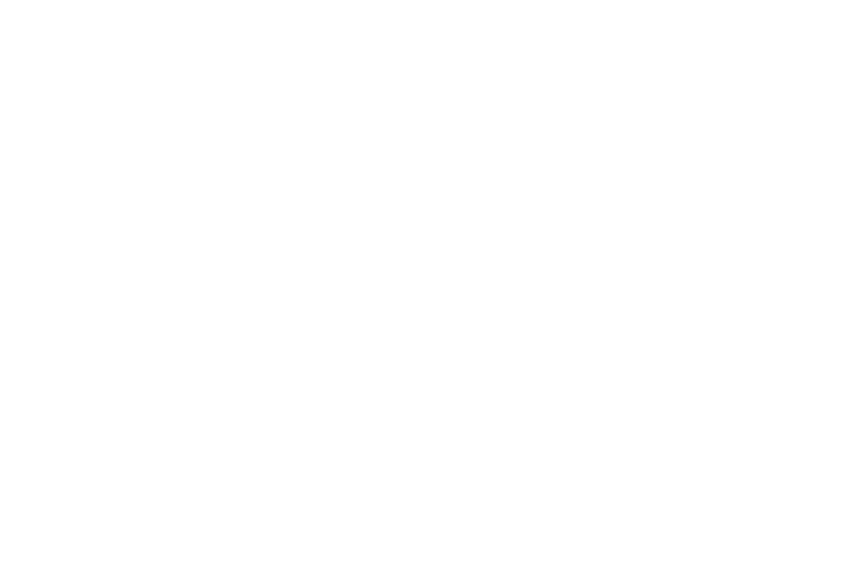

In [8]:
remove_dim = True
pca = True

# NOTE: currently the train and test sets are combined

# split = int(len(x_train)*0.8)
# x_train, x_val = x_train[:split], x_train[split:]
# y_train, y_val = y_train[:split], y_train[split:]

x_train = np.concatenate([x_train, x_test], axis=0)
y_train = np.concatenate([y_train, y_test], axis=0)

# plt.scatter(x_test[:,0], x_test[:,1], c=y_test)
# g = plot(x_train, y_train)
g = plot(x_test, y_test)

In [9]:
if pca:
    n_clusters = latent_dim + 1
else:
    n_clusters = latent_dim

bsize = 512

batch_sizes = {
    'Unlabeled': bsize,
    'Labeled': bsize,
    'Orthonorm': bsize,
    }

input_shape = x_train.shape[1:]
y_true = tf.placeholder(tf.float32, shape=(None, n_clusters), name='y_true')
y_train_labeled_onehot = np.empty((0, len(np.unique(y_train))))
inputs = {
    'Unlabeled': Input(shape=input_shape, name='UnlabeledInput'),
    'Labeled': Input(shape=input_shape, name='LabeledInput'),
    'Orthonorm': Input(shape=input_shape, name='OrthonormInput'),
    }
k = 3
spectral_net = SpectralNet(inputs, arch,
            None, y_true, y_train_labeled_onehot,
            n_clusters, affinity='full', scale_nbr=k, n_nbrs=k, 
            batch_sizes=batch_sizes, siamese_net=None, 
            x_train=x_train, have_labeled=len(x_train))

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [10]:
spectral_net.train(
        x_train, np.zeros_like(x_train[0:0]), x_test,
        lr=5e-5, drop=0.1, patience=30, num_epochs=100)

Epoch: 0, loss=0.305845, val_loss=0.007899
Epoch: 1, loss=0.180806, val_loss=0.002864
Epoch: 2, loss=0.067097, val_loss=0.000890
Epoch: 3, loss=0.026625, val_loss=0.000703
Epoch: 4, loss=0.024809, val_loss=0.000685
Epoch: 5, loss=0.024914, val_loss=0.000689
Epoch: 6, loss=0.024436, val_loss=0.000692
Epoch: 7, loss=0.024322, val_loss=0.000665
Epoch: 8, loss=0.024222, val_loss=0.000705
Epoch: 9, loss=0.024313, val_loss=0.000712
Epoch: 10, loss=0.024312, val_loss=0.000686
Epoch: 11, loss=0.024479, val_loss=0.000670
Epoch: 12, loss=0.024549, val_loss=0.000669
Epoch: 13, loss=0.023983, val_loss=0.000690
Epoch: 14, loss=0.024537, val_loss=0.000679
Epoch: 15, loss=0.024353, val_loss=0.000671
Epoch: 16, loss=0.024017, val_loss=0.000667
Epoch: 17, loss=0.024173, val_loss=0.000667
Epoch: 18, loss=0.023884, val_loss=0.000668
Epoch: 19, loss=0.024241, val_loss=0.000676
Epoch: 20, loss=0.024038, val_loss=0.000689
Epoch: 21, loss=0.024377, val_loss=0.000671
Epoch: 22, loss=0.023732, val_loss=0.00068

(array([0.30584456, 0.18080599, 0.06709726, 0.02662507, 0.02480902,
        0.02491393, 0.02443596, 0.02432192, 0.02422186, 0.02431326,
        0.02431154, 0.02447921, 0.02454887, 0.02398337, 0.02453656,
        0.02435315, 0.02401659, 0.02417322, 0.0238844 , 0.02424138,
        0.02403779, 0.02437685, 0.02373195, 0.02388831, 0.02403702,
        0.02373385, 0.02383751, 0.02377867, 0.02427768, 0.02386295,
        0.02415308, 0.02433277, 0.02371954, 0.02418871, 0.0239284 ,
        0.02394666, 0.02390841, 0.02408348, 0.02368616, 0.02428337,
        0.02405604, 0.02381991, 0.02389314, 0.02410052, 0.02431098,
        0.02414131, 0.02377097, 0.02384591, 0.02380625, 0.0237539 ,
        0.02404537, 0.02401771, 0.02374327, 0.02401593, 0.02423829,
        0.02400765, 0.02389719, 0.0242061 , 0.02387939, 0.02381575,
        0.02368653, 0.02407508, 0.0236241 , 0.02360895, 0.02408293,
        0.02379613, 0.02434853, 0.02397388, 0.02381656, 0.023685  ,
        0.02382064, 0.02424487, 0.02394451, 0.02

<IPython.core.display.Javascript object>


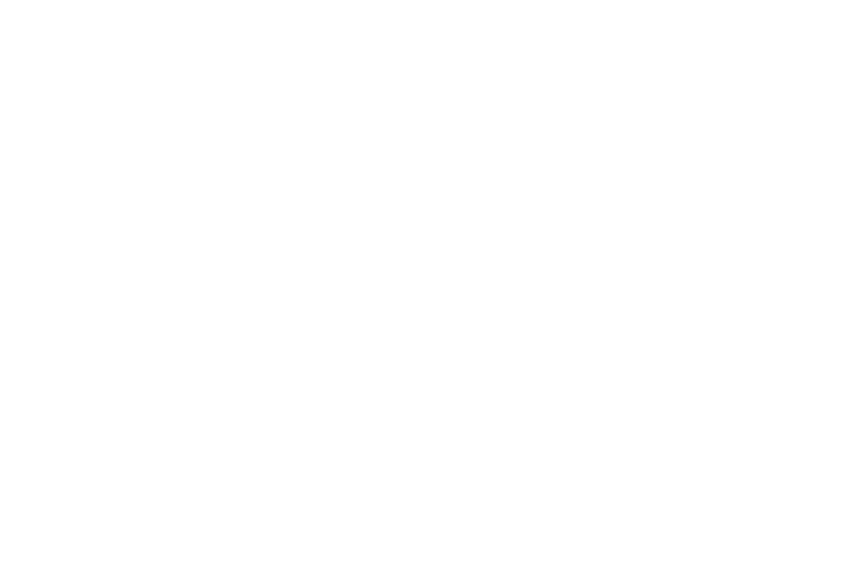

range of y_pred values: 1.4735450744628906 - -1.3639113903045654


In [11]:
y_pred = spectral_net.predict(x_test)
g = plot(y_pred[:,:3], y_test)
print('range of y_pred values: {} - {}'.format(np.max(y_pred), np.min(y_pred)))

<IPython.core.display.Javascript object>


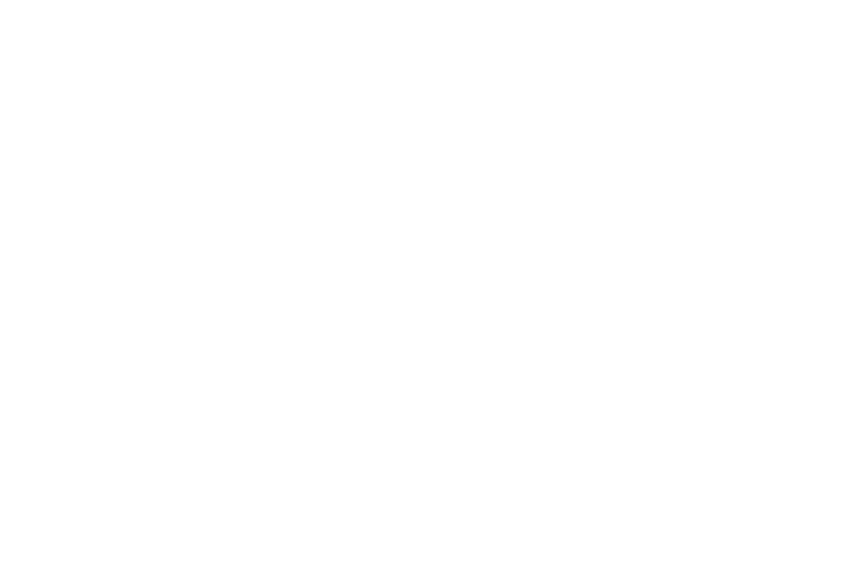

In [12]:
# now plot all the dimensions of spectralnet
y_pred_embedded = TSNE().fit_transform(y_pred)
g = plot(y_pred_embedded[:,:2], y=y_test)

In [13]:
svg = SVG(inputs, spectralnet=spectral_net, orig_dim=x_train.shape[-1], remove_dim=remove_dim, pca=pca)

In [14]:
if pca:
    svg.train_pca(x_train, epochs=75)
    svg.pca_layers[0].trainable = False
    svg.pca_layers[1].trainable = False

Epoch 1/75
 - 1s - loss: 748.5602
Epoch 2/75


/usr/local/lib/python3.5/dist-packages/keras/callbacks.py:569: RuntimeWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: loss
  (self.monitor, ','.join(list(logs.keys()))), RuntimeWarning


 - 0s - loss: 564.8662
Epoch 3/75
 - 0s - loss: 454.7615
Epoch 4/75
 - 0s - loss: 377.4687
Epoch 5/75
 - 0s - loss: 316.4840
Epoch 6/75
 - 0s - loss: 265.3853
Epoch 7/75
 - 0s - loss: 221.5752
Epoch 8/75
 - 0s - loss: 183.2675
Epoch 9/75
 - 0s - loss: 148.5820
Epoch 10/75
 - 0s - loss: 115.8127
Epoch 11/75
 - 0s - loss: 84.9225
Epoch 12/75
 - 0s - loss: 57.5485
Epoch 13/75
 - 0s - loss: 35.7537
Epoch 14/75
 - 0s - loss: 20.5643
Epoch 15/75
 - 0s - loss: 11.3213
Epoch 16/75
 - 0s - loss: 6.3314
Epoch 17/75
 - 0s - loss: 3.7999
Epoch 18/75
 - 0s - loss: 2.4934
Epoch 19/75
 - 0s - loss: 1.7486
Epoch 20/75
 - 0s - loss: 1.2696
Epoch 21/75
 - 0s - loss: 0.9334
Epoch 22/75
 - 0s - loss: 0.6869
Epoch 23/75
 - 0s - loss: 0.5034
Epoch 24/75
 - 0s - loss: 0.3656
Epoch 25/75
 - 0s - loss: 0.2630
Epoch 26/75
 - 0s - loss: 0.1872
Epoch 27/75
 - 0s - loss: 0.1314
Epoch 28/75
 - 0s - loss: 0.0910
Epoch 29/75
 - 0s - loss: 0.0621
Epoch 30/75
 - 0s - loss: 0.0418
Epoch 31/75
 - 0s - loss: 0.0278
Epoch 

<IPython.core.display.Javascript object>


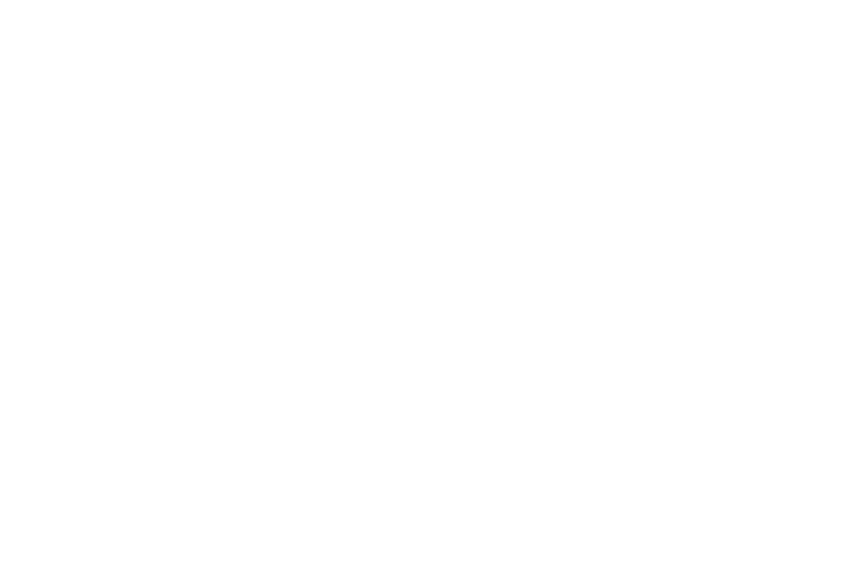

In [15]:
if pca:
    y_pred = svg.pc.predict(x_test)
    plt.axis('equal')
    g = plot(y_pred[:,:3], y_test)

In [16]:
svg.train(x_train, epochs=1000, batch_size=512)

/usr/local/lib/python3.5/dist-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


0 [VAE loss: 1633.7274169921875] [reconstruction_loss: 12195.435546875] [mu_loss: 12166.1220703125] [kl_loss: 3160.54345703125] [pca_loss: 0.10777463018894196] [neighbor_loss: 224.27574157714844]
25 [VAE loss: 80.60643768310547] [reconstruction_loss: 2301.409423828125] [mu_loss: 553.8995361328125] [kl_loss: 150.6319580078125] [pca_loss: 6.056967258453369] [neighbor_loss: 546.9949951171875]
50 [VAE loss: 31.611953735351562] [reconstruction_loss: 2547.800537109375] [mu_loss: 186.06509399414062] [kl_loss: 150.47146606445312] [pca_loss: 8.072717666625977] [neighbor_loss: 152.2193145751953]
75 [VAE loss: 26.807981491088867] [reconstruction_loss: 2781.29052734375] [mu_loss: 131.0416717529297] [kl_loss: 65.21408081054688] [pca_loss: 8.252863883972168] [neighbor_loss: 125.802734375]
100 [VAE loss: 18.695449829101562] [reconstruction_loss: 2962.760009765625] [mu_loss: 109.26945495605469] [kl_loss: 51.03385925292969] [pca_loss: 9.061883926391602] [neighbor_loss: 80.0091552734375]
125 [VAE loss: 

KeyboardInterrupt: 

# ANALYSIS

In [17]:
# %matplotlib

<IPython.core.display.Javascript object>


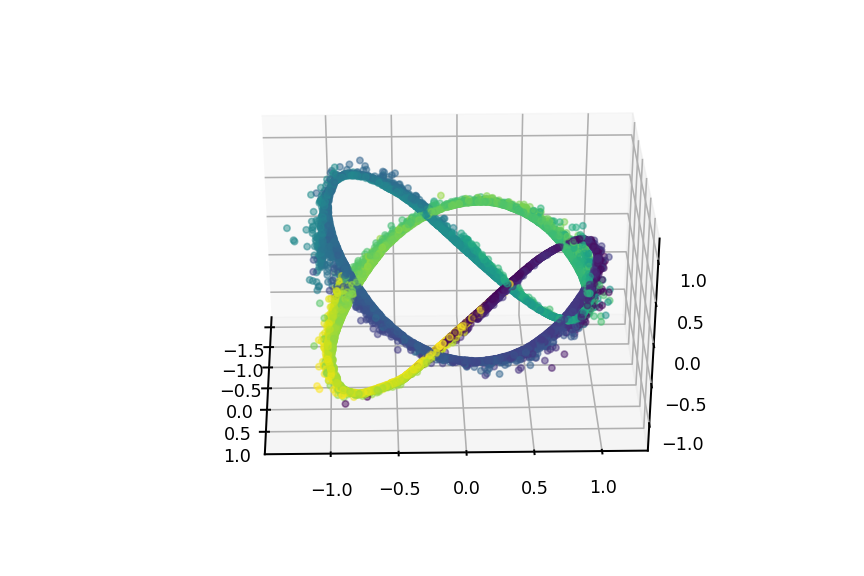

In [18]:
# plot generated points
x_gen = svg.generate_from_samples(x_train)
# g = plot(x_gen, y_train, x2=x_train, s2=0)
g = plot(x_gen, y_train)

In [19]:
cov_dim = latent_dim - 1 if remove_dim else latent_dim

In [20]:
cov_dim

1

In [21]:
# get number of neighbors within one standard deviation of each element in x_test
_, _mu, _sigma_v, _sigma_lam = svg.generate_from_samples(x_test, return_mu_sigma=True)
_sigma_v = _sigma_v.reshape(-1, latent_dim, cov_dim)

num_close = []
for i in range(len(_mu)):
    l, v, m = np.exp(0.5 * -_sigma_lam[i,:]), _sigma_v[i,:], _mu[i,:]
    left_cov = np.einsum('ij,j->ij', v, l)
    cov = np.einsum('ij,kj->ik', left_cov, v)
    scaled_dists = np.einsum('jk,ik->ij', cov, _mu - m)
    # consider as neighbors all points within the variance of x_i
    less_than_std = np.abs(scaled_dists) < 1
    less_than_std = np.logical_and(less_than_std[:,0], less_than_std[:,1])
    # split neighbors into those of the same class and those of a different class
    same, diff = (y_test[less_than_std] == y_test[i]), (y_test[less_than_std] != y_test[i])
    num_close.append((np.sum(same), np.sum(diff)))

In [22]:
centered = (_sigma_v - np.mean(_sigma_v, axis=0)).reshape(_sigma_v.shape[:-1])
_cov = centered.T.dot(centered) / len(_sigma_v)
print('MEAN VALUE\n', np.mean(np.sqrt(_sigma_lam), axis=0))
print('MEAN VECTOR\n', np.mean(_sigma_v, axis=0))
print('COVARIANCE\n', _cov)

MEAN VALUE
 [0.69319536]
MEAN VECTOR
 [[-0.36037777]
 [ 0.52703089]]
COVARIANCE
 [[0.35985849 0.18009187]
 [0.18009187 0.23250782]]


### COVARIANCE TESTING

In [23]:
get_fn1 = K.function([svg.input], [svg.z_sqrt_var])
get_fn2 = K.function([svg.input], [svg.x_enc])

In [24]:
epsilon = np.random.normal(0, .5, size=_mu.shape)

In [25]:
_sigma_v.shape

(1500, 2, 1)

ALSO (1500, 2, 2) (1500, 2, 2)
ERROR 22.41641105660346


<IPython.core.display.Javascript object>


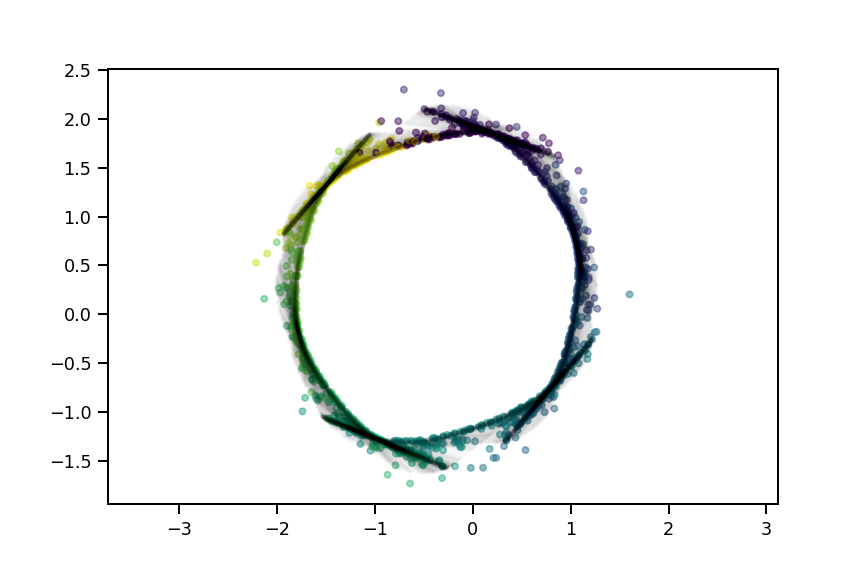

(-2.4135274511024054,
 1.7976181131049689,
 -1.9387185516775127,
 2.5073597374380108)

In [26]:
# compute sigmas
_, _mu, _sigma_v, _sigma_lam = svg.generate_from_samples(x_test, return_mu_sigma=True)
_sigma_v = _sigma_v.reshape(-1, latent_dim, cov_dim)
# _sigma_v = np.einsum('ijk->ikj', _sigma_v)
# _sigma_lam = np.flip(_sigma_lam, axis=1)
_sigma = np.einsum('ijk,ilk->ijl', np.einsum('ijk,ik->ijk', _sigma_v, np.exp(0.5 * _sigma_lam[:,:1])), _sigma_v)

# verify sigmas
_z_sqrt_var = predict_with_K_fn(get_fn1, x_test)[0].reshape((-1, latent_dim, latent_dim))

# verify encoding
_x_enc = predict_with_K_fn(get_fn2, x_test)[0]

print("ALSO", _sigma.shape, _z_sqrt_var.shape)
print('ERROR', np.linalg.norm(_sigma - _z_sqrt_var))

# epsilon = np.random.normal(size=_mu.shape)
perturbations = np.einsum('ijk,ik->ij', _sigma, epsilon)
# perturbations = epsilon

single_perturbed_x = np.array([_mu[0,:]] * len(_mu)) + np.einsum('jk,ik->ij', _sigma[0,:], epsilon)
perturbed_x = _mu + perturbations
# g = plot(x=_mu, y=y_test)
# g = plot(x=perturbed_x, y=y_test, x2=_mu, s2=100)
# g = plot(perturbed_x, y=y_test)#, x2=_mu, s2=100)
g = plot(_x_enc, y=y_test)
# plt.figure()

idxs = np.random.permutation(len(_mu))
for i in idxs:
    idx = np.argmax(_sigma_lam[i])
    delta = _sigma_v[i,:,idx] * np.sqrt(_sigma_lam[i, idx])
    start = _mu[i] + delta
    end = _mu[i] - delta
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', lw=2, alpha=0.01)
    
plt.axis('equal')

# plt.scatter(_mu[idxs, 0], _mu[idxs, 1], s=200)
# plt.plot([0, 1], [1, 2])

In [ ]:
# compute sigmas
_, _mu, _sigma_v, _sigma_lam = svg.generate_from_samples(x_test, return_mu_sigma=True)
_sigma_v = _sigma_v.reshape(-1, latent_dim, cov_dim)
# _sigma_v = np.einsum('ijk->ikj', _sigma_v)
# _sigma_lam = np.flip(_sigma_lam, axis=1)
_sigma = np.einsum('ijk,ilk->ijl', np.einsum('ijk,ik->ijk', _sigma_v, np.sqrt(_sigma_lam)), _sigma_v)

epsilon = np.random.normal(size=_mu.shape)
perturbations = np.einsum('ijk,ik->ij', _sigma, epsilon)

single_perturbed_x = np.array([_mu[0,:]] * len(_mu)) + np.einsum('jk,ik->ij', _sigma[0,:], epsilon)
perturbed_x = _mu + perturbations
g = plot(_mu, x2=perturbed_x, s2=20)
plt.axis('equal')

idxs = np.random.permutation(len(_mu))
for i in idxs:
    idx = np.argmax(_sigma_lam[i])
    delta = _sigma_v[i, idx] * _sigma_lam[i, idx] / 8
    start = _mu[i] + delta
    end = _mu[i] - delta
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', lw=2, alpha=0.1)
    
for i in idxs:
    idx = np.argmin(_sigma_lam[i])
    delta = _sigma_v[i,:,idx] * np.sqrt(_sigma_lam[i, idx])
    start = _mu[i] + delta
    end = _mu[i] - delta
    plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', lw=2, alpha=0.1)
#     plt.plot([_mu[i,0], _mu[i,0]], [_mu[i,1] + .1, _mu[i,1]])

# plt.scatter(_mu[idxs, 0], _mu[idxs, 1], s=200)
# plt.plot([0, 1], [1, 2])

In [ ]:
# CHEKING MATRIX MATH

# TEST MATRIX STACK x VECTOR STACK (REPRESENTING DIAGONALS)
n_stacks = 1500
n = 10

# generate matrices
matrices = []
diagonals = []
products = []
for i in range(n_stacks):
    matrix = _sigma_v[i,:,:]
    diagonal = np.sqrt(_sigma_lam[i,:])
    product = np.dot(np.dot(matrix, np.diag(diagonal)), matrix.T)
    matrices.append(matrix)
    diagonals.append(diagonal)
    products.append(product)
    
matrix_stack = np.concatenate([np.expand_dims(m, axis=0) for m in matrices], axis=0)
diagonals_stack = np.concatenate([np.expand_dims(d, axis=0) for d in diagonals], axis=0)
product_stack = np.einsum('ijk,ilk->ijl', np.einsum('ijk,ik->ijk', matrix_stack, diagonals_stack), matrix_stack)

diffs = []
diffs2 = []
diffs3 = []
for i in range(n_stacks):
    diff = np.sum(products[i] - product_stack[i,:,:])
    diff2 = np.sum(products[i] - _sigma[i,:,:])
    diff3 = np.sum(products[i] - _z_sqrt_var[i,:,:])
    diffs.append(diff)
    diffs2.append(diff2)
    diffs3.append(diff3)
    
print("ERRORS")
print(sum(diffs))
print(sum(diffs2))
print(sum(diffs3))

In [ ]:
i_ = np.random.randint(0, len(_mu))
# i_ = 0
print(_sigma[i_].dot(_sigma_v[i_]))
print(np.linalg.norm(_sigma[i_].dot(_sigma_v[i_])))
print(np.sqrt(_sigma_lam[i_]))
print(_sigma_v[i_])
print(epsilon[i_])
print(_sigma[i_].dot(epsilon[i_]))
print(perturbed_x[i_])
print(_mu[i_])

In [ ]:
i_ = np.random.randint(0, len(_mu))
tmp = np.expand_dims(_sigma[i_].dot(epsilon[i_]), axis=0)
tmp2 = perturbed_x[i_-1:i_]
tmp3 = np.expand_dims(np.einsum('ij,j->j', _sigma[i_], epsilon[i_]), axis=0)
tmp4 = np.expand_dims(np.einsum('ij,j->i', _sigma[i_], epsilon[i_]), axis=0)
print('tmp', tmp)
print('tmp2', tmp2)
print('tmp3', tmp3, np.linalg.norm(tmp3/_mu[i_]))
print('tmp4', tmp4, np.linalg.norm(tmp4/_mu[i_]))
g = plot(_mu[i_:i_+1], x2=_mu[i_] + tmp, s=1000, s2=300)
plt.scatter(_mu[:,0], _mu[:,1])
idx = np.argmax(_sigma_lam[i])
delta = _sigma_v[i_,:,idx] * np.sqrt(_sigma_lam[i_, idx])
start = _mu[i_] + delta
end = _mu[i_] - delta
plt.plot([start[0], end[0]], [start[1], end[1]], 'k-', lw=2, alpha=1)
plt.axis('equal')

### BILIPSCHITZ TESTING

In [ ]:
# differentiate decoder with respect to inputs to compute another jacobian, and then evaluate it on the same point
_jacobian = [tf.expand_dims(tf.gradients(svg.x_recon[:,i], svg.x_enc)[0], 1) for i in range(svg.x_recon.shape[1])]
jacobian = tf.reduce_sum(tf.concat(_jacobian, axis=1), axis=0)
v = tf.reshape(svg.z_cov_vectors, (-1, latent_dim, cov_dim))
v = tf.Print(v, [tf.shape(v), tf.shape(svg.z_cov_values)], 'PRINT')
temp = tf.einsum('ijk,ik->ijk', v, tf.sqrt(svg.z_cov_values[:,:1]))
print(v.get_shape(), svg.z_cov_values.get_shape(), temp.get_shape())
B = tf.einsum('ijk,ilk->ijl', temp, v)
B = tf.reduce_mean(B, axis=0)
cov = tf.matmul(jacobian, tf.matmul(B, jacobian, transpose_b=True))
cov = tf.reshape(cov, (x_test[0].shape[0], x_test[0].shape[0]))

In [ ]:
# create burst from a point and compute covariance matrix
burst_size = 1000
rand_idx = np.random.randint(len(x_test))
x_ = x_test[rand_idx]
# x_ = np.array((np.cos(.25), np.sin(.25)))
x_arr = np.array([x_] * burst_size)
x_rec, x_mu, x_sigma_v, x_sigma_lam = svg.generate_from_samples(x_arr, return_mu_sigma=True)

cov_burst = np.cov((x_rec - np.mean(x_rec, axis=0)).T)

# run gradient burst"
# cov_grad = K.get_session().run([svg.x_recon, cov, B, jacobian], feed_dict={svg.input: np.array([x_]*1)})
cov_grad = K.get_session().run([cov], feed_dict={svg.input: np.array([x_]*1)})[0]

In [ ]:
cov_burst

In [ ]:
cov_grad

In [ ]:
l_burst, _ = np.linalg.eig(cov_burst)
l_grad, _ = np.linalg.eig(cov_grad)
l_burst = np.sort(l_burst)[::-1]
l_grad = np.sort(l_grad)[::-1]
print('l_burst:', l_burst, l_burst/l_burst[0])
print('l_grad:', l_grad, l_grad/l_grad[0])

In [ ]:
g = plot(x_rec, x2=x_test, label1='true', label2='predicted')

In [ ]:
x__ = np.expand_dims(x_, axis=0)
g = plot(x__, x2=x_test, alpha=.1, label1='true', label2='predicted')

In [ ]:
g = plot(x_test)

### RANDOM WALK TESTING

In [ ]:
# RANDOM WALK
def walk(f, x_arr, branch_factor=5, n_steps=20, max_size=1000):
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
    for i in range(n_steps):
        x_arr = np.array([x_arr] * branch_factor).reshape([-1, x_.shape[0]])
        (x_arr, x_mu, x_sigma) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:1000]
        x_arr, x_mu, x_sigma = x_arr[p], x_mu[p], x_sigma[p]
        
    return x_arr, x_mu, x_sigma

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True, normalize_cov=0.1)
y_test_sz = np.mean(f(x_all)[3], axis=1)
sz_max = np.max(y_test_sz)
sz_min = np.min(y_test_sz)
y_test_sz = (y_test_sz - sz_min)/(sz_max - sz_min) * 5
print(np.min(y_test_sz), np.max(y_test_sz))
y_test_sz = np.exp(0.5 * y_test_sz)

In [ ]:
import matplotlib.animation

# which space do we want to plot in?
plot_latent = True
plot_idx = 1 if plot_latent else 0

x_arr = np.random.permutation(x_test)[:100]
x__ = f(x_all)[plot_idx]
x_ = f(x_arr)[plot_idx]
x_tot = np.concatenate([x_, x__], axis=0)
y_tot = np.concatenate([np.zeros(shape=(len(x_arr),)), np.ones(shape=(len(x__),))*2], axis=0)
y_sz = np.concatenate([np.ones(shape=(len(x_arr),))*5, y_test_sz], axis=0)

def update_graph(num):
    global x_arr
    global x__
    global y_tot
    x_arr, x_mu, x_sigma_v, x_sigma_lam = f(x_arr)
    # plot in latent or original space
    x_ = x_mu if plot_latent else x_arr
    
    x_ = np.concatenate([x_, x__], axis=0)
    
    if x_.shape[1] == 3:
        graph._offsets3d = (x_[:,0], x_[:,1], x_[:,2])
        ax.view_init(elev=10, azim=num*4)
    elif x_.shape[1] == 2:
        graph.set_offsets(np.c_[x_[:,0], x_[:,1]])
        
    title.set_text('Walk, time={}'.format(num))

fig = plt.figure(figsize=(12.8, 7.2))
projection = '3d' if x_.shape[1] == 3 else None
ax = fig.add_subplot(111, projection=projection)
title = ax.set_title('Walk, time=0')

if x_.shape[1] == 3:
    graph = ax.scatter(x_tot[:,0], x_tot[:,1], x_tot[:,2], c=y_tot, s=y_sz, alpha=0.4)
elif x_.shape[1] == 2:
    graph = ax.scatter(x_tot[:,0], x_tot[:,1], c=y_tot, s=y_sz, alpha=0.4)

ani = matplotlib.animation.FuncAnimation(fig, update_graph, 180, 
                               interval=200, blit=False)

In [ ]:
from IPython.display import HTML
HTML(ani.to_html5_video(embed_limit=None))

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True, normalize_cov=False)
def walk(f, x_arr, branch_factor=5, n_steps=20, max_size=1000):
    p = np.random.permutation(len(x_arr))[:1000]
    x_arr = x_arr[p]
    for i in range(n_steps):
        print(x_arr.shape, branch_factor)
        x_arr = np.array([x_arr] * branch_factor).reshape([-1, x_.shape[1]])
        (x_arr, x_mu, x_sigma_v, x_sigma_lam) = f(x_arr)
        p = np.random.permutation(len(x_arr))[:1000]
        x_arr, x_mu, x_sigma_v, x_sigma_lam = x_arr[p], x_mu[p], x_sigma_v[p], x_sigma_lam[p]
        
    return x_arr, x_mu, x_sigma

In [ ]:
f = partial(svg.generate_from_samples, return_mu_sigma=True)

x_test_sample = np.random.permutation(x_test)[:10]
x_arr, x_sigma, x_mu = walk(f, x_test_sample)

In [ ]:
g = plot(x_arr, x2=x_test, label1='predicted', label2='true')

In [ ]:
# g = plot(x_mu, x2=f(x_test_sample)[1])
g = plot(x_mu, x2=f(x_test)[1])

In [ ]:
g = plot(x_arr)

In [ ]:
print("samar was here")